Much of this code will be copied from code elsewhere

This is an update with the new HN implementation, so I cannot set the HN rate at a given time, it's determined by the metallicity.

In [1]:
from collections import defaultdict
import numpy as np
import tabulation
from tabulation import Lifetimes
from tabulation import IMF
from scipy import integrate
from tqdm.notebook import tqdm
import cmocean
from matplotlib import colors as mpl_colors
from matplotlib import cm
from astropy import table

import betterplotlib as bpl
bpl.set_style()

In [2]:
import sys, os
sys.path.append(os.path.abspath("../../build/"))

In [3]:
from core_enrich_ia_elts_cluster_discrete import lib as core
from snia_enrich_ia_elts_cluster          import lib as snia_continuous
from snii_enrich_ia_elts_cluster          import lib as snii_continuous
from agb_enrich_ia_elts_cluster_discrete  import lib as agb
from wind_enrich_ia_elts_cluster_discrete import lib as winds

In [4]:
core.detailed_enrichment_init()
snia_continuous.detailed_enrichment_init()
snii_continuous.detailed_enrichment_init()
agb.detailed_enrichment_init()
winds.detailed_enrichment_init()

In [5]:
lt = Lifetimes("Raiteri_96")
imf = IMF("Kroupa", 0.08, 50, total_mass=1)

# generate history

In [6]:
dt_sn = 1E5
dt_agb = 1E7

In [7]:
def ceil_to_nearest(num, scale):
    test_values = np.arange(0, num+2*scale, scale)
    for val in test_values:
        if val - scale > num:
            return val

In [8]:
times = dict()
turnoff_masses = dict()
def generate_times(zs):
    for z in zs:
        split = ceil_to_nearest(lt.lifetime(8.0, z), dt_sn)
        times[z] = np.concatenate([np.arange(0, split, dt_sn),
                                   np.arange(split, 14E9, dt_agb)])
        turnoff_masses[z] = [lt.turnoff_mass(t, z) for t in tqdm(times[z])]

In [9]:
zs_nice = [0.02 / 10**i for i in [0, 1, 2, 3, 4]]
zs = zs_nice #+ [0.01, 0.006, 0.004, 0.001, 0.0001]

In [10]:
generate_times(zs)

In [11]:
solar_metallicities = {"Z":0.02, "C":2.78E-3, "N":8.14E-4, "O":7.56E-3,
                       "Mg":6.45E-4, "S":4.79E-4, "Ca":6.41E-5, "Fe":1.23E-3}

In [12]:
elts = ["C", "N", "O", "Mg", "S", "Ca", "Fe"]
all_fields = elts + ["Z_II", "Z_Ia", "Z_AGB", "Z", "total", "E", "N_SN", "N_SN_left"]
sn_ii_idxs = {"C": 0, "N": 1, "O":2, "Mg":3, "S":4, "Ca": 5, "Fe": 6,
              "Z_II": 7, "Z": 7, "total": 8, "E": 9, "N_SN": 10, "N_SN_left": 11}
agb_idxs = {"C": 0, "N": 1, "O":2, "Mg":3, "S":4, "Ca": 5, "Fe": 6,
           "Z_AGB": 7, "Z": 7, "total":8}
sn_ia_idxs = {"C": 0, "N": 1, "O":2, "Mg":3, "S":4, "Ca": 5, "Fe": 6,
              "Z_Ia": 7, "Z": 7, "total": 7, "E": 8, "N_SN_left": 9}
# The raw yields doesn't return some elements, since those are scaled based on
# the metallicity of the star
agb_idxs_yields = {"C": 0, "N": 1, "O":2, "Mg":3, "Z_AGB":4, "total": 5}

class SNHistory(object):
    def __init__(self, stellar_mass, z):
        
        self.mass = stellar_mass
        self.z = z
        
        self.age_50 = lt.lifetime(50.0, self.z)
        
        self.times = times[z]
        self.turnoff_masses = turnoff_masses[z]
        
        
        self.sn_ii_func = snii_continuous.get_ejecta_sn_ii_py
        self.sn_ia_func = snia_continuous.sn_ia_core_py
        
        self.sn_ia_start = lt.lifetime(8.0, self.z)
        
        self.yields = defaultdict(list)
        self.cumulative = defaultdict(list)
        
        self.yields_sn_ii = defaultdict(list)
        self.cumulative_sn_ii = defaultdict(list)
        
        self.yields_sn_ia = defaultdict(list)
        self.cumulative_sn_ia = defaultdict(list)
        
        self.yields_agb = defaultdict(list)
        self.cumulative_agb = defaultdict(list)
        
        self.yields_winds = defaultdict(list)
        self.cumulative_winds = defaultdict(list)
        
        self.handle_history()
        
    def handle_history(self, verbose=False):
        self.unexploded_sn_ii = 0
        self.unexploded_sn_ia = 0
        
        for idx in range(len(self.turnoff_masses) - 1):
            m_now  = self.turnoff_masses[idx]
            m_next = self.turnoff_masses[idx+1]
            age_now = self.times[idx]
            age_next = self.times[idx+1]
            dt = age_next - age_now
            sn_ii_yields = self.sn_ii_func(self.unexploded_sn_ii, m_now, m_next, self.mass, self.z)
            agb_yields = agb.get_ejecta_agb_py(m_now, m_next, self.mass, self.z,
                                               (self.z/0.02) * solar_metallicities["S"],
                                               (self.z/0.02) * solar_metallicities["Ca"],
                                               (self.z/0.02) * solar_metallicities["Fe"])
            sn_ia_yields = self.sn_ia_func(self.unexploded_sn_ia, age_now, dt,
                                           self.mass, self.z, self.sn_ia_start)
            winds_yields = winds.get_ejecta_winds_py(age_now, age_next, 
                                                     m_now, m_next, 
                                                     self.mass, self.z, self.age_50)
            
            for field in all_fields:
                if field in sn_ii_idxs:
                    this_sn_ii_yield = sn_ii_yields[sn_ii_idxs[field]]
                else:
                    this_sn_ii_yield = 0
                    
                if field in sn_ia_idxs:
                    this_sn_ia_yield = sn_ia_yields[sn_ia_idxs[field]]
                elif field == "N_SN":
                    this_sn_ia_yield = sn_ia_yields[sn_ia_idxs["E"]] / 2E51
                else:
                    this_sn_ia_yield = 0
                    
                
                if field in agb_idxs:
                    this_agb_yield = agb_yields[agb_idxs[field]]
                else:
                    this_agb_yield = 0
                    
                if field == "total":
                    this_wind_yield = winds_yields
                elif field in elts:
                    this_wind_yield = winds_yields * (self.z/0.02) * solar_metallicities[field]
                else:
                    this_wind_yield = 0
                
                total_yield = this_sn_ii_yield + this_sn_ia_yield + this_agb_yield + this_wind_yield
                
                self.yields_sn_ii[field].append(this_sn_ii_yield / dt)
                self.yields_sn_ia[field].append(this_sn_ia_yield / dt)
                self.yields_agb[field].append(this_agb_yield / dt)
                self.yields_winds[field].append(this_wind_yield / dt)
                self.yields[field].append(total_yield / dt)
                
                if len(self.cumulative[field]) == 0:
                    self.cumulative[field].append(total_yield)
                else:
                    self.cumulative[field].append(self.cumulative[field][-1] + total_yield)
                    
                if len(self.cumulative_sn_ii[field]) == 0:
                    self.cumulative_sn_ii[field].append(this_sn_ii_yield)
                else:
                    self.cumulative_sn_ii[field].append(self.cumulative_sn_ii[field][-1] + this_sn_ii_yield)
                    
                if len(self.cumulative_sn_ia[field]) == 0:
                    self.cumulative_sn_ia[field].append(this_sn_ia_yield)
                else:
                    self.cumulative_sn_ia[field].append(self.cumulative_sn_ia[field][-1] + this_sn_ia_yield)
                    
                if len(self.cumulative_agb[field]) == 0:
                    self.cumulative_agb[field].append(this_agb_yield)
                else:
                    self.cumulative_agb[field].append(self.cumulative_agb[field][-1] + this_agb_yield)
                    
                if len(self.cumulative_winds[field]) == 0:
                    self.cumulative_winds[field].append(this_wind_yield)
                else:
                    self.cumulative_winds[field].append(self.cumulative_winds[field][-1] + this_wind_yield)
        

In [13]:
mass = 1

histories = {z: SNHistory(mass, z) for z in zs}

# HN fraction

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


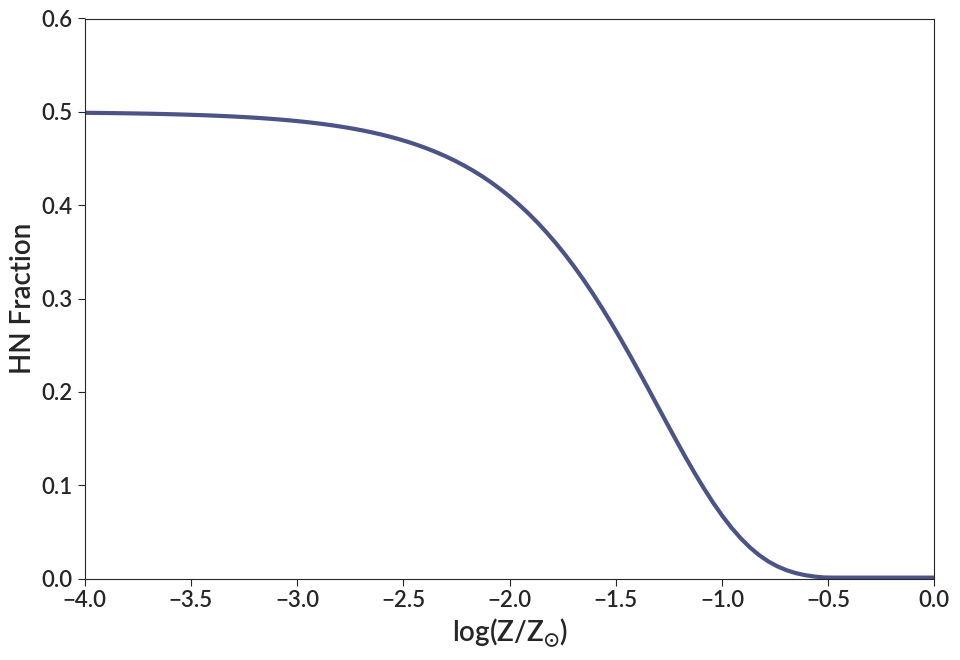

In [14]:
fig, ax = bpl.subplots()
z_raw = np.logspace(-6, np.log10(0.02), 100)
z_plot = np.log10(z_raw / 0.02)

hn_fraction = [snii_continuous.get_hn_fraction_py(z) for z in z_raw]

ax.plot(z_plot, hn_fraction)
ax.add_labels("log(Z/$Z_{\odot}$)", "HN Fraction")
ax.set_limits(-4, 0, 0, 0.6)
fig.savefig("hn_fraction_new.png", bbox_inches="tight")

# Metallicity ratios

In [15]:
def plot_metallicity_ratio_evolution(ax, field, include_total):
    ratios = []
    
    for z in zs:
        this_obj = histories[z]
        
        total_x  = this_obj.cumulative_sn_ii[field][-1]
        total_fe = this_obj.cumulative_sn_ii["Fe"][-1]
        
        if include_total:
            total_x += this_obj.cumulative_sn_ia[field][-1]
            total_x += this_obj.cumulative_agb[field][-1]
            total_x += this_obj.cumulative_winds[field][-1]

            total_fe += this_obj.cumulative_sn_ia["Fe"][-1]
            total_fe += this_obj.cumulative_agb["Fe"][-1]
            total_fe += this_obj.cumulative_winds["Fe"][-1]
        
        this_x_on_fe = np.log10(total_x / total_fe) - np.log10(solar_metallicities[field] / solar_metallicities["Fe"])
        ratios.append(this_x_on_fe)
        
    
    log_z_rel = [np.log10(z/0.02) for z in zs]

    ax.plot(log_z_rel, ratios)

In [16]:
data = table.Table.read("./gc_data.txt", format="ascii")

In [17]:
def plot_data(ax, elt):
    # there are two options for x data
    feI  = data["[FeI/H]"]
    feII = data["[FeII/H]"]
    feI_err  = data["e[FeI/H]"]
    feII_err = data["e_[FeII/H]"]
    elt_data = data["[{}/Fe]".format(elt)]
    elt_data_err = data["e_[{}/Fe]".format(elt)]
    
    x_values = []
    y_values = []
    y_errs = []
    for f1, ef1, f2, ef2, x, x_err in zip(feI, feI_err, feII, feII_err, elt_data, elt_data_err):
        if x_err > 1:
            continue
        
        good_fe = []
        if ef1 < 1:
            good_fe.append(f1)
        if ef2 < 1:
            good_fe.append(f2)
            
        if len(good_fe) == 0:
            continue
        
        x_values.append(np.mean(good_fe))
        y_values.append(x)
        y_errs.append(x_err)
        
    ax.scatter(x_values, y_values, c="0.5")
    ax.errorbar(x_values, y_values, yerr=y_errs, c="0.5", markersize=0)

In [18]:
def plot_ratio_evolution(ax, field, all_sources):
    

#     ax.set_xscale("log")
    if all_sources:
        label = "[{}/Fe] of all ejecta".format(field)
    else:
        label = "[{}/Fe]".format(field)
        #"[{}/Fe] of SNII ejecta".format(field)
        
    ax.add_labels("log(Z/$Z_{\odot}$)", label)
    
    plot_metallicity_ratio_evolution(ax, field, all_sources)

#     ax.legend(frameon=False)
    if elt != "N":
        ax.set_limits(-3, 0, -0.5, 1.0)
    ax.axhline(0, ls=":", c="0.3")


In [19]:
not_fe_elts = elts = ["C", "N", "O", "Mg", "S", "Ca"]

No handles with labels found to put in legend.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


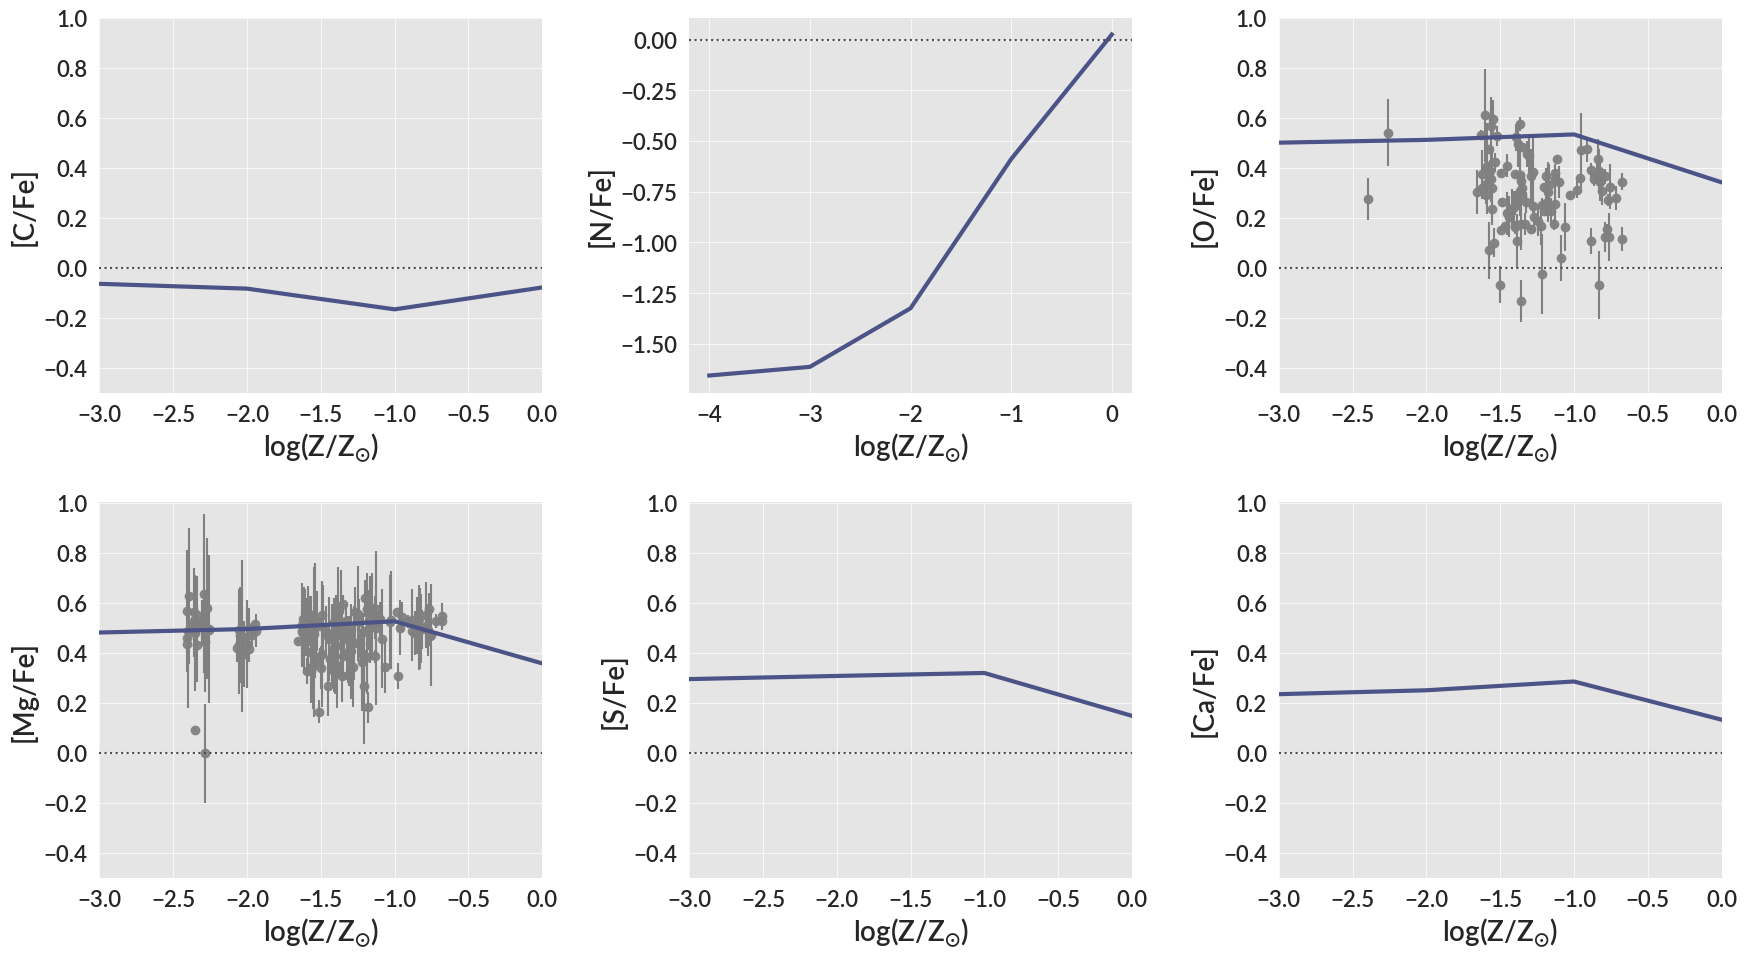

In [20]:
fig, axs = bpl.subplots(ncols=3, nrows=2, figsize=[18, 10], tight_layout=True)
axs = axs.flatten()

for ax, elt in zip(axs, not_fe_elts):
    plot_ratio_evolution(ax, elt, False)
    ax.make_ax_dark()
    
axs[1].legend(frameon=False)
plot_data(axs[2], "O")
plot_data(axs[3], "Mg")

# fig.savefig("hn_fraction_new_yields.png")

First Generation O is high, Mg should be pretty typical


# Plot energy

In [21]:
old_sn_low = 3E6
old_sn_high = 1.5E7 + 3E6

old_number_snii = integrate.quad(imf.normalized_dn_dm, 8.0, 40.0)[0]  # calculated the same way

def old_sn_rate(age, cluster_mass=1):
    if age < old_sn_low:
        return 0
    if age > old_sn_high:
        return 0
    
    phi_per_dt = 1.0 / age
    rate = phi_per_dt * cluster_mass * old_number_snii
    return rate

def old_sn_energies(age):
    return 1E51 * old_sn_rate(age)

In [22]:
old_ages = np.linspace(0, 45E6, 1000)
old_e_rates = [old_sn_energies(a) for a in old_ages]
old_e_cum = integrate.cumtrapz(x=old_ages, y=old_e_rates, initial=0) / 1E49

In [23]:
cmap = bpl.cm.lajolla
norm = mpl_colors.LogNorm(vmin=1E-5, vmax=1)
hn_mappable = cm.ScalarMappable(norm, cmap)
def z_color(z):
    return hn_mappable.to_rgba(z)

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


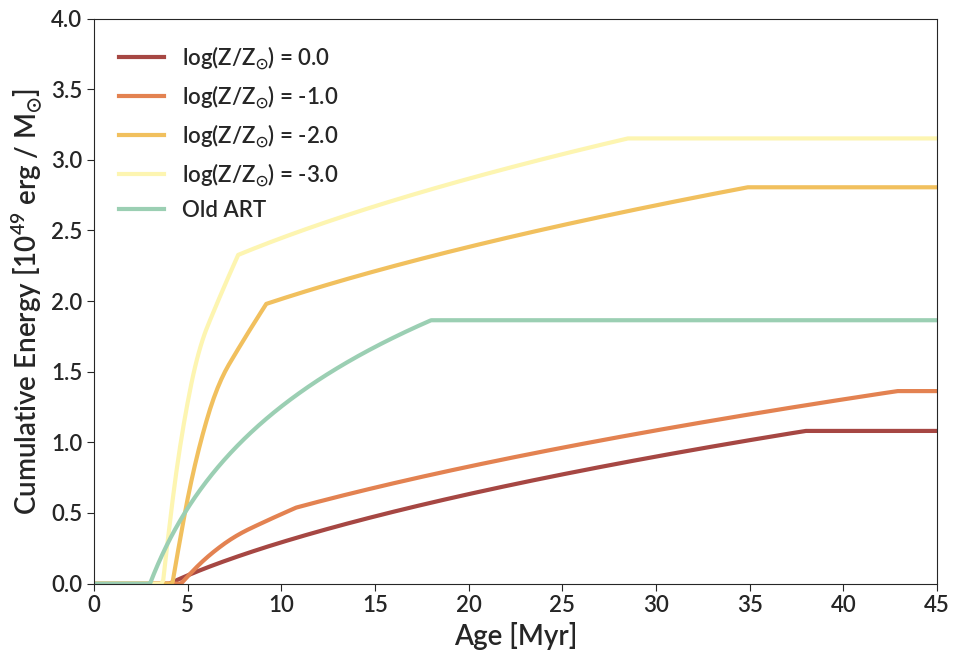

In [24]:
fig, ax = bpl.subplots()
for z in zs_nice[:-1]:
    plot_times = times[z][1:]
    
    ax.add_labels("Age [Myr]", "Cumulative Energy [10$^{49}$ erg / $M_{\odot}$]")

    this_obj = histories[z]
    ax.plot(plot_times / 1E6, 
            np.array(this_obj.cumulative_sn_ii["E"]) / (1E49 * mass), 
            c=z_color(z),
            label="log(Z/$Z_{\odot}$) = " + "{:.1f}".format(np.log10(z/0.02)))

ax.plot(old_ages/1E6, old_e_cum, c=bpl.color_cycle[1], label="Old ART")

ax.legend(frameon=False, fontsize=16)

ax.set_limits(0, 45, 0, 4)

# fig.savefig("hn_fraction_new_energy.png", bbox_inches="tight")